This reads in a file pulled by the scraping scripts in the adjacent folder.

A simple Logistic Regression performed best, so I stayed with that. Left the SVD out since it didn't change things much.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import linear_model, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import RandomForestRegressor as rfr

from xgboost import XGBClassifier as xgb
import string
from sklearn.pipeline import TransformerMixin, FeatureUnion, make_pipeline, make_union
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline

from nltk.tokenize import word_tokenize #, PunktSentenceTokenizer, 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, matutils
import time, random

In [2]:
def uniqueweights(dataframe, column):
    uniques = list(set(dataframe[column]))
    d = {}
    for unique in uniques:
        d[unique] = sum(dataframe[column] == unique)
    minimum = min(d.values())
    for unique in uniques:
        d[unique] = minimum/d[unique]
    return d

def rebalance(dataframe, column, number_per_val = 'min'):
    if number_per_val == 'min':
        number_per_val = min(list(dataframe[column].value_counts()))
    columns = list(dataframe[column].unique())
    column_chunks = []
    for value in columns:
        data_column = dataframe[dataframe[column] == value] 
        data_column_sub, junk = train_test_split(data_column, test_size = 1 - (number_per_val/len(data_column)))
        column_chunks.append(data_column_sub)
    return pd.concat(column_chunks)

In [3]:
data = pd.read_csv('/Users/derekupdegraff/Metis_Class/Fletcher_Scraping/collected_text.csv', names = ['century', 'text'])
data.head()

,century,text
0,17,"vndcNorvve:mporibus iJlis i,in perpecuum Cam..."
1,17,215 23 ) r Bruno Ryvcs gives a remarkable inst...
2,17,"Cor. Sdeath,vs' hat a humorous fellow is this/..."
3,17,"AmohinÃ¡base el perro, y, dando ladridos y au..."
4,17,A cleane fpirit and vndefiled Co ule is the d...


In [4]:
data.century.value_counts()

19    15974
18     5677
20     4852
17     1393
21       44
Name: century, dtype: int64

In [5]:
data = data[data.century > 17]
data = data[data.century < 21]
data.head()

,century,text
1393,18,And till he an fivers like a Logician to Dr.Ru...
1394,18,The Glory of EttgiaaJ yiis arriv'd to -fjie a...
1395,18,"I what I fhould do next, a good Woman (in all ..."
1396,18,it cannot be wondered at : And that they were ...
1397,18,"1 For a complete list of these Editions, see t..."


In [6]:
data = rebalance(data, 'century')
data.century.value_counts()

20    4852
18    4852
19    4851
Name: century, dtype: int64

In [7]:
for i in [18, 19, 20]:
    data[str(i)+'th'] = (data['century'] == i) + 0
# data['20'] = (data['century'] == 20) + 0
# data['19'] = (data['century'] == 19) + 0
# data['18'] = (data['century'] == 18) + 0
data.head()

,century,text,18th,19th,20th
3809,18,That now had chang'd her former wonted hue : ...,1,0,0
1906,18,pel of Chrift ; of all which thou mayfl: find ...,1,0,0
3617,18,"born to trample on their fellow creatures, wit...",1,0,0
1996,18,the Law of God have puhlick Authority given un...,1,0,0
1447,18,"i)cfiy and Tour SubjeBs, and indeed to /ri? Eu...",1,0,0


In [8]:
# SUBSET FOR SPEED
# data_sub, junk = train_test_split(data, test_size = 0.8)
data_sub = data
data_sub.head()

,century,text,18th,19th,20th
3809,18,That now had chang'd her former wonted hue : ...,1,0,0
1906,18,pel of Chrift ; of all which thou mayfl: find ...,1,0,0
3617,18,"born to trample on their fellow creatures, wit...",1,0,0
1996,18,the Law of God have puhlick Authority given un...,1,0,0
1447,18,"i)cfiy and Tour SubjeBs, and indeed to /ri? Eu...",1,0,0


In [9]:
X, y = data_sub['text'], data_sub[['18th', '19th', '20th', 'century']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

def subset(mytext, minlen = 100):
    return mytext[:mytext[minlen:].find('.') + minlen]

X_train_short = X_test.apply(subset, 1)
X_test_short = X_test.apply(subset, 1)


18th Century

Train Score: 0.965204725536
Test Score: 0.947332264713
AUC Score: 0.967458738614

19th Century

Train Score: 0.899002160867
Test Score: 0.844744675979
AUC Score: 0.909447775377

20th Century

Train Score: 0.956210434418
Test Score: 0.89031371651
AUC Score: 0.959228219846


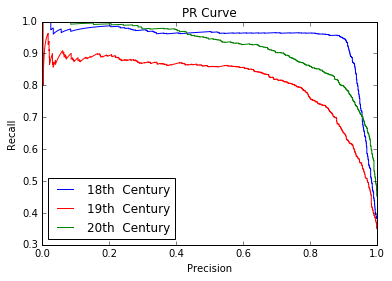

In [10]:
# Lots of modeling in other places; found logistic regression was at least as good as others. 

models_lr = {}
for i in [18,19,20]:
    model= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = False, stop_words = 'english')),
                     ('tfidf', TfidfTransformer()), 
                     ('model', LogisticRegression()),])
    model.fit(X_train, y_train[str(i) + 'th'])
    pred = model.predict(X_test)
    print('\n' + str(i) + 'th Century\n')
    print("Train Score: " + str(np.mean(cross_validation.cross_val_score(model, X_train, y_train[str(i)+'th'], scoring='roc_auc'))))
    print('Test Score: ' + str(model.score(X_test, y_test[str(i)+'th'])))
    print('AUC Score: ' + str(roc_auc_score(y_test[str(i)+'th'], model.predict_proba(X_test)[:,1])))
    models_lr[i] = model
    
colors = 'brg'
for i in [18,19,20]:
    probs = models_lr[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test[str(i)+'th'], probs)
    plt.plot(recall, precision, c = colors[i-18], label = str(i) + 'th  Century')
    plt.title('PR Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc = 'best')


18th Century

Train Score: 0.956189474107
Test Score: 0.938172658576
AUC Score: 0.960476834646

19th Century

Train Score: 0.861855770167
Test Score: 0.786352186856
AUC Score: 0.869184666704

20th Century

Train Score: 0.925270549276
Test Score: 0.844744675979
AUC Score: 0.927648180393


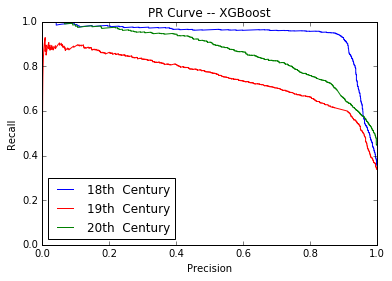

In [11]:
models_xgb = {}
for i in [18,19,20]:
    model= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = False, stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('model', xgb()),])
    model.fit(X_train, y_train[str(i) + 'th'])
    pred = model.predict(X_test)
    print('\n' + str(i) + 'th Century\n')
    print("Train Score: " + str(np.mean(cross_validation.cross_val_score(model, X_train, y_train[str(i)+'th'], scoring='roc_auc'))))
    print('Test Score: ' + str(model.score(X_test, y_test[str(i)+'th'])))
    print('AUC Score: ' + str(roc_auc_score(y_test[str(i)+'th'], model.predict_proba(X_test)[:,1])))
    models_xgb[i] = model
    

colors = 'brg'
for i in [18,19,20]:
    probs = models_xgb[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test[str(i)+'th'], probs)
    plt.plot(recall, precision, c = colors[i-18], label = str(i) + 'th  Century')
    plt.title('PR Curve -- XGBoost')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc = 'best')


18th Century

Train Score: 0.945563309797
Test Score: 0.946187313946
AUC Score: 0.9542466696

19th Century

Train Score: 0.805832024955
Test Score: 0.748339821388
AUC Score: 0.813093376181

20th Century

Train Score: 0.891603519578
Test Score: 0.822990611404
AUC Score: 0.899627009102


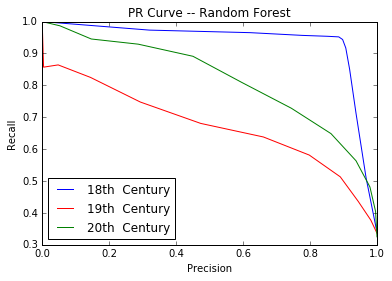

In [12]:
models_rf = {}
for i in [18,19,20]:
    model= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = False, stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('model', rf()),])
    model.fit(X_train, y_train[str(i) + 'th'])
    pred = model.predict(X_test)
    print('\n' + str(i) + 'th Century\n')
    print("Train Score: " + str(np.mean(cross_validation.cross_val_score(model, X_train, y_train[str(i)+'th'], scoring='roc_auc'))))
    print('Test Score: ' + str(model.score(X_test, y_test[str(i)+'th'])))
    print('AUC Score: ' + str(roc_auc_score(y_test[str(i)+'th'], model.predict_proba(X_test)[:,1])))
    models_rf[i] = model
    

colors = 'brg'
for i in [18,19,20]:
    probs = models_rf[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test[str(i)+'th'], probs)
    plt.plot(recall, precision, c = colors[i-18], label = str(i) + 'th  Century')
    plt.title('PR Curve -- Random Forest')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc = 'best')


18th Century

Train Score: 0.892271416533
Test Score: 0.807877261278
AUC Score: 0.908193884047

19th Century

Train Score: 0.845372716036
Test Score: 0.794366842226
AUC Score: 0.845672730332

20th Century

Train Score: 0.871548596412
Test Score: 0.788871078544
AUC Score: 0.876820491049


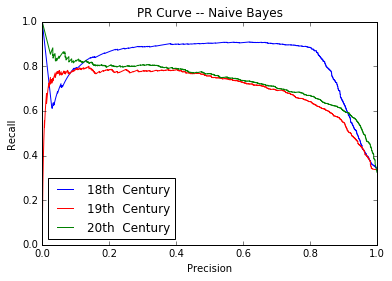

In [14]:
models_nb = {}
for i in [18,19,20]:
    model= Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), lowercase = False, stop_words = 'english')),
                     ('tfidf', TfidfTransformer()), ('svd', TruncatedSVD(n_components = 100)),
                     ('model', GaussianNB()),])
    model.fit(X_train, y_train[str(i) + 'th'])
    pred = model.predict(X_test)
    print('\n' + str(i) + 'th Century\n')
    print("Train Score: " + str(np.mean(cross_validation.cross_val_score(model, X_train, y_train[str(i)+'th'], scoring='roc_auc'))))
    print('Test Score: ' + str(model.score(X_test, y_test[str(i)+'th'])))
    print('AUC Score: ' + str(roc_auc_score(y_test[str(i)+'th'], model.predict_proba(X_test)[:,1])))
    models_nb[i] = model
    

colors = 'brg'
for i in [18,19,20]:
    probs = models_nb[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test[str(i)+'th'], probs)
    plt.plot(recall, precision, c = colors[i-18], label = str(i) + 'th  Century')
    plt.title('PR Curve -- Naive Bayes')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc = 'best')

In [15]:
def probest(mystring, modelsdict = models_lr):
    estimate_probs = {}
    total = 0
    for key in modelsdict.keys():
        estimate_probs[key] = modelsdict[key].predict_proba([mystring])[0][1]
    # estimate_probs = np.asarray(estimate_numbers)/sum(estimate_numbers)
    totalprob = sum(estimate_probs.values())
    for key in modelsdict.keys():
        estimate_probs[key] = estimate_probs[key]/totalprob
    return estimate_probs#, mystring

In [16]:
maxes, mins = {}, {}
for i in [18, 19, 20]:
    coefs = list(models_lr[i].named_steps['model'].coef_[0])[:]
    features = models_lr[i].named_steps['vect'].get_feature_names()[:]
    maxstuff, minstuff = [], []
    while (len(maxstuff) > 9) * (len(minstuff) > 9) < 1:
        maxind, minind = coefs.index(max(coefs)), coefs.index(min(coefs))
        maxstuff.append([features[maxind], coefs[maxind]])
        coefs[coefs.index(max(coefs))] = 0
        minstuff.append([features[minind], coefs[minind]])
        coefs[coefs.index(min(coefs))] = 0
    maxes[i], mins[i] = maxstuff, minstuff
maxes[18]

[['fo', 6.340479882648709],
 ['thofe', 4.9286083775847773],
 ['thefe', 4.7675959687684735],
 ['fuch', 4.7432181023206956],
 ['fome', 4.7022737127726861],
 ['fame', 4.4273464581399748],
 ['firft', 3.7071101000249604],
 ['moft', 3.6125024960095002],
 ['muft', 3.1846124987591464],
 ['feveral', 2.9849626173182751]]

In [17]:
# Principia Mathematica; 1729 translation
probest("If any force generates a motion, a double force will generate double the motion, a triple force triple the motion, whether that force be impressed altogether and at once, or gradually and successively. And this motion (being always directed the same way with the generating force), if the body moved before, is added to or subtracted from the former motion, according as they directly conspire with or are directly contrary to each other; or obliquely joined, when they are oblique, so as to produce a new motion compounded from the determination of both.")

{18: 0.37840791209282632, 19: 0.34914536905617932, 20: 0.27244671885099442}

In [18]:
# US Declaration of independence 1776
probest("When in the Course of human events, it becomes necessary for one people to dissolve the political bands which have connected them with another, and to assume among the powers of the earth, the separate and equal station to which the Laws of Nature and of Nature's God entitle them, a decent respect to the opinions of mankind requires that they should declare the causes which impel them to the separation.")

{18: 0.29883546307778086, 19: 0.50283428929498653, 20: 0.19833024762723267}

In [19]:
# David Ricardo, On the Principles of Political Economy and Taxation (Early 19th century)
probest("The writer, in combating received opinions, has found it necessary to advert more particularly to those passages in the writings of Adam Smith from which he sees reason to differ; but he hopes it will not, on that account, be suspected that he does not, in common with all those who acknowledge the importance of the science of Political Economy, participate in the admiration which the profound work of this celebrated author so justly excites.")

{18: 0.25502697215056791, 19: 0.59835775257042456, 20: 0.14661527527900764}

In [20]:
# Gettysburg Address (1863)
probest("Four score and seven years ago our fathers brought forth on this continent a new nation, conceived in liberty, and dedicated to the proposition that all men are created equal. Now we are engaged in a great civil war, testing whether that nation, or any nation so conceived and so dedicated, can long endure. We are met on a great battlefield of that war. We have come to dedicate a portion of that field, as a final resting place for those who here gave their lives that that nation might live. It is altogether fitting and proper that we should do this. But, in a larger sense, we can not dedicate, we can not consecrate, we can not hallow this ground. The brave men, living and dead, who struggled here, have consecrated it, far above our poor power to add or detract. The world will little note, nor long remember what we say here, but it can never forget what they did here. It is for us the living, rather, to be dedicated here to the unfinished work which they who fought here have thus far so nobly advanced. It is rather for us to be here dedicated to the great task remaining before us—that from these honored dead we take increased devotion to that cause for which they gave the last full measure of devotion—that we here highly resolve that these dead shall not have died in vain—that this nation, under God, shall have a new birth of freedom—and that government of the people, by the people, for the people, shall not perish from the earth.")

{18: 0.10716211250350702, 19: 0.4459615198125515, 20: 0.4468763676839414}

In [21]:
# War of the Worlds (1898)
probest("No one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than man's and yet as mortal as his own; that as men busied themselves about their various concerns they were scrutinised and studied, perhaps almost as narrowly as a man with a microscope might scrutinise the transient creatures that swarm and multiply in a drop of water. With infinite complacency men went to and fro over this globe about their little affairs, serene in their assurance of their empire over matter. It is possible that the infusoria under the microscope do the same. No one gave a thought to the older worlds of space as sources of human danger, or thought of them only to dismiss the idea of life upon them as impossible or improbable. It is curious to recall some of the mental habits of those departed days. At most terrestrial men fancied there might be other men upon Mars, perhaps inferior to themselves and ready to welcome a missionary enterprise. Yet across the gulf of space, minds that are to our minds as ours are to those of the beasts that perish, intellects vast and cool and unsympathetic, regarded this earth with envious eyes, and slowly and surely drew their plans against us. And early in the twentieth century came the great disillusionment.")

{18: 0.10899478164639025, 19: 0.22660851717752808, 20: 0.66439670117608163}

In [22]:
# Star Trek Opening (1966)
probest("Space: the final frontier. These are the voyages of the starship Enterprise. Its five-year mission: to explore strange new worlds, to seek out new life and new civilizations, to boldly go where no man has gone before.")

{18: 0.13009896444746427, 19: 0.26537195629041527, 20: 0.60452907926212041}

In [23]:
# Neuromancer Opening (1984)
probest("The sky above the port was the color of television, tuned to a dead channel. 'It's not like I'm using,' Case heard someone say, as he shouldered his way through the crowd around the door of the Chat. 'It's like my body's developed this massive drug deficiency.' It was a Sprawl voice and a Sprawl joke. The Chatsubo was a bar for professional expatriates; you could drink there for a week and never hear two words in Japanese.")

{18: 0.088906512756083439, 19: 0.14371313013481379, 20: 0.76738035710910268}